## Algorithm Description

This notebook performs a comprehensive statistical analysis and visualization of the longitudinal distribution of Sunspot Groups (SG) and Solar Flares (SF), comparing Carrington longitudes ($L_{\mathrm{cr}}$) with Ecliptic longitudes ($\lambda$).

### Key Components of the Analysis:

1.  **Data Preprocessing & Normalization**:
    *   Loads historical sunspot data (1874–2025) and solar flare records (1975–2017).
    *   Converts flare classes (B, C, M, X) into numerical intensities for weighted analysis.

2.  **Earth Visibility Correction**:
    *   Implements a rigorous weight correction module using **JPL Ephemeris data**.
    *   Accounts for Earth's non-uniform orbital velocity to eliminate artificial clustering signals in ecliptic coordinates, providing a more accurate baseline than simple Keplerian approximations.

3.  **Statistical Framework**:
    *   **Circular Statistics**: Uses the **Kuiper Test** to evaluate the global uniformity of distributions.
    *   **Interval Statistics**: Calculates normalized counts and weighted means (Area/Intensity) across longitude bins, applying **FDR (False Discovery Rate)** correction to identify locally significant peaks.
    *   **Scan Statistics**: Employs a sliding window approach to visualize smoothed trends and active longitudes.
    *   **Permutation Tests**: Conducts dual permutation tests (Standard and Cyclic) to validate the global significance of observed patterns against red noise and random fluctuations.

4.  **Visualization & Export**:
    *   Generates a high-resolution 5x4 multi-panel figure comparing different solar activity stages (Onset, Dissolution, etc.) and flare classes.
    *   Features dual-axis plots showing both event frequency (bars) and physical magnitude (points).
    *   Exports all statistical metrics and significance flags to a structured Excel file for further verification.

--- [Init] Loading JPL Ephemeris: ../../data/ready/781_planets_dwarfs_asteroids_lonlat.parquet ---
--- [Success] JPL Earth Weights Initialized (Rigorous Mode) ---
--- Sunspot Data loaded: 5 datasets ---
--- Flare Base Data loaded: 39039 records ---

--- Running Analysis (Parallel Comparison Mode) ---
>> Row 1: Spot=[Onset SG] vs Flare=[X-Class]
>> Row 2: Spot=[Diss. SG] vs Flare=[M-Class]
>> Row 3: Spot=[Dur. SG] vs Flare=[C-Class]
>> Row 4: Spot=[Daily SG] vs Flare=[B-Class]
>> Row 5: Spot=[All SG] vs Flare=[All Flares]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



--- Done. Visual Mode Plot & Excel Generated. ---


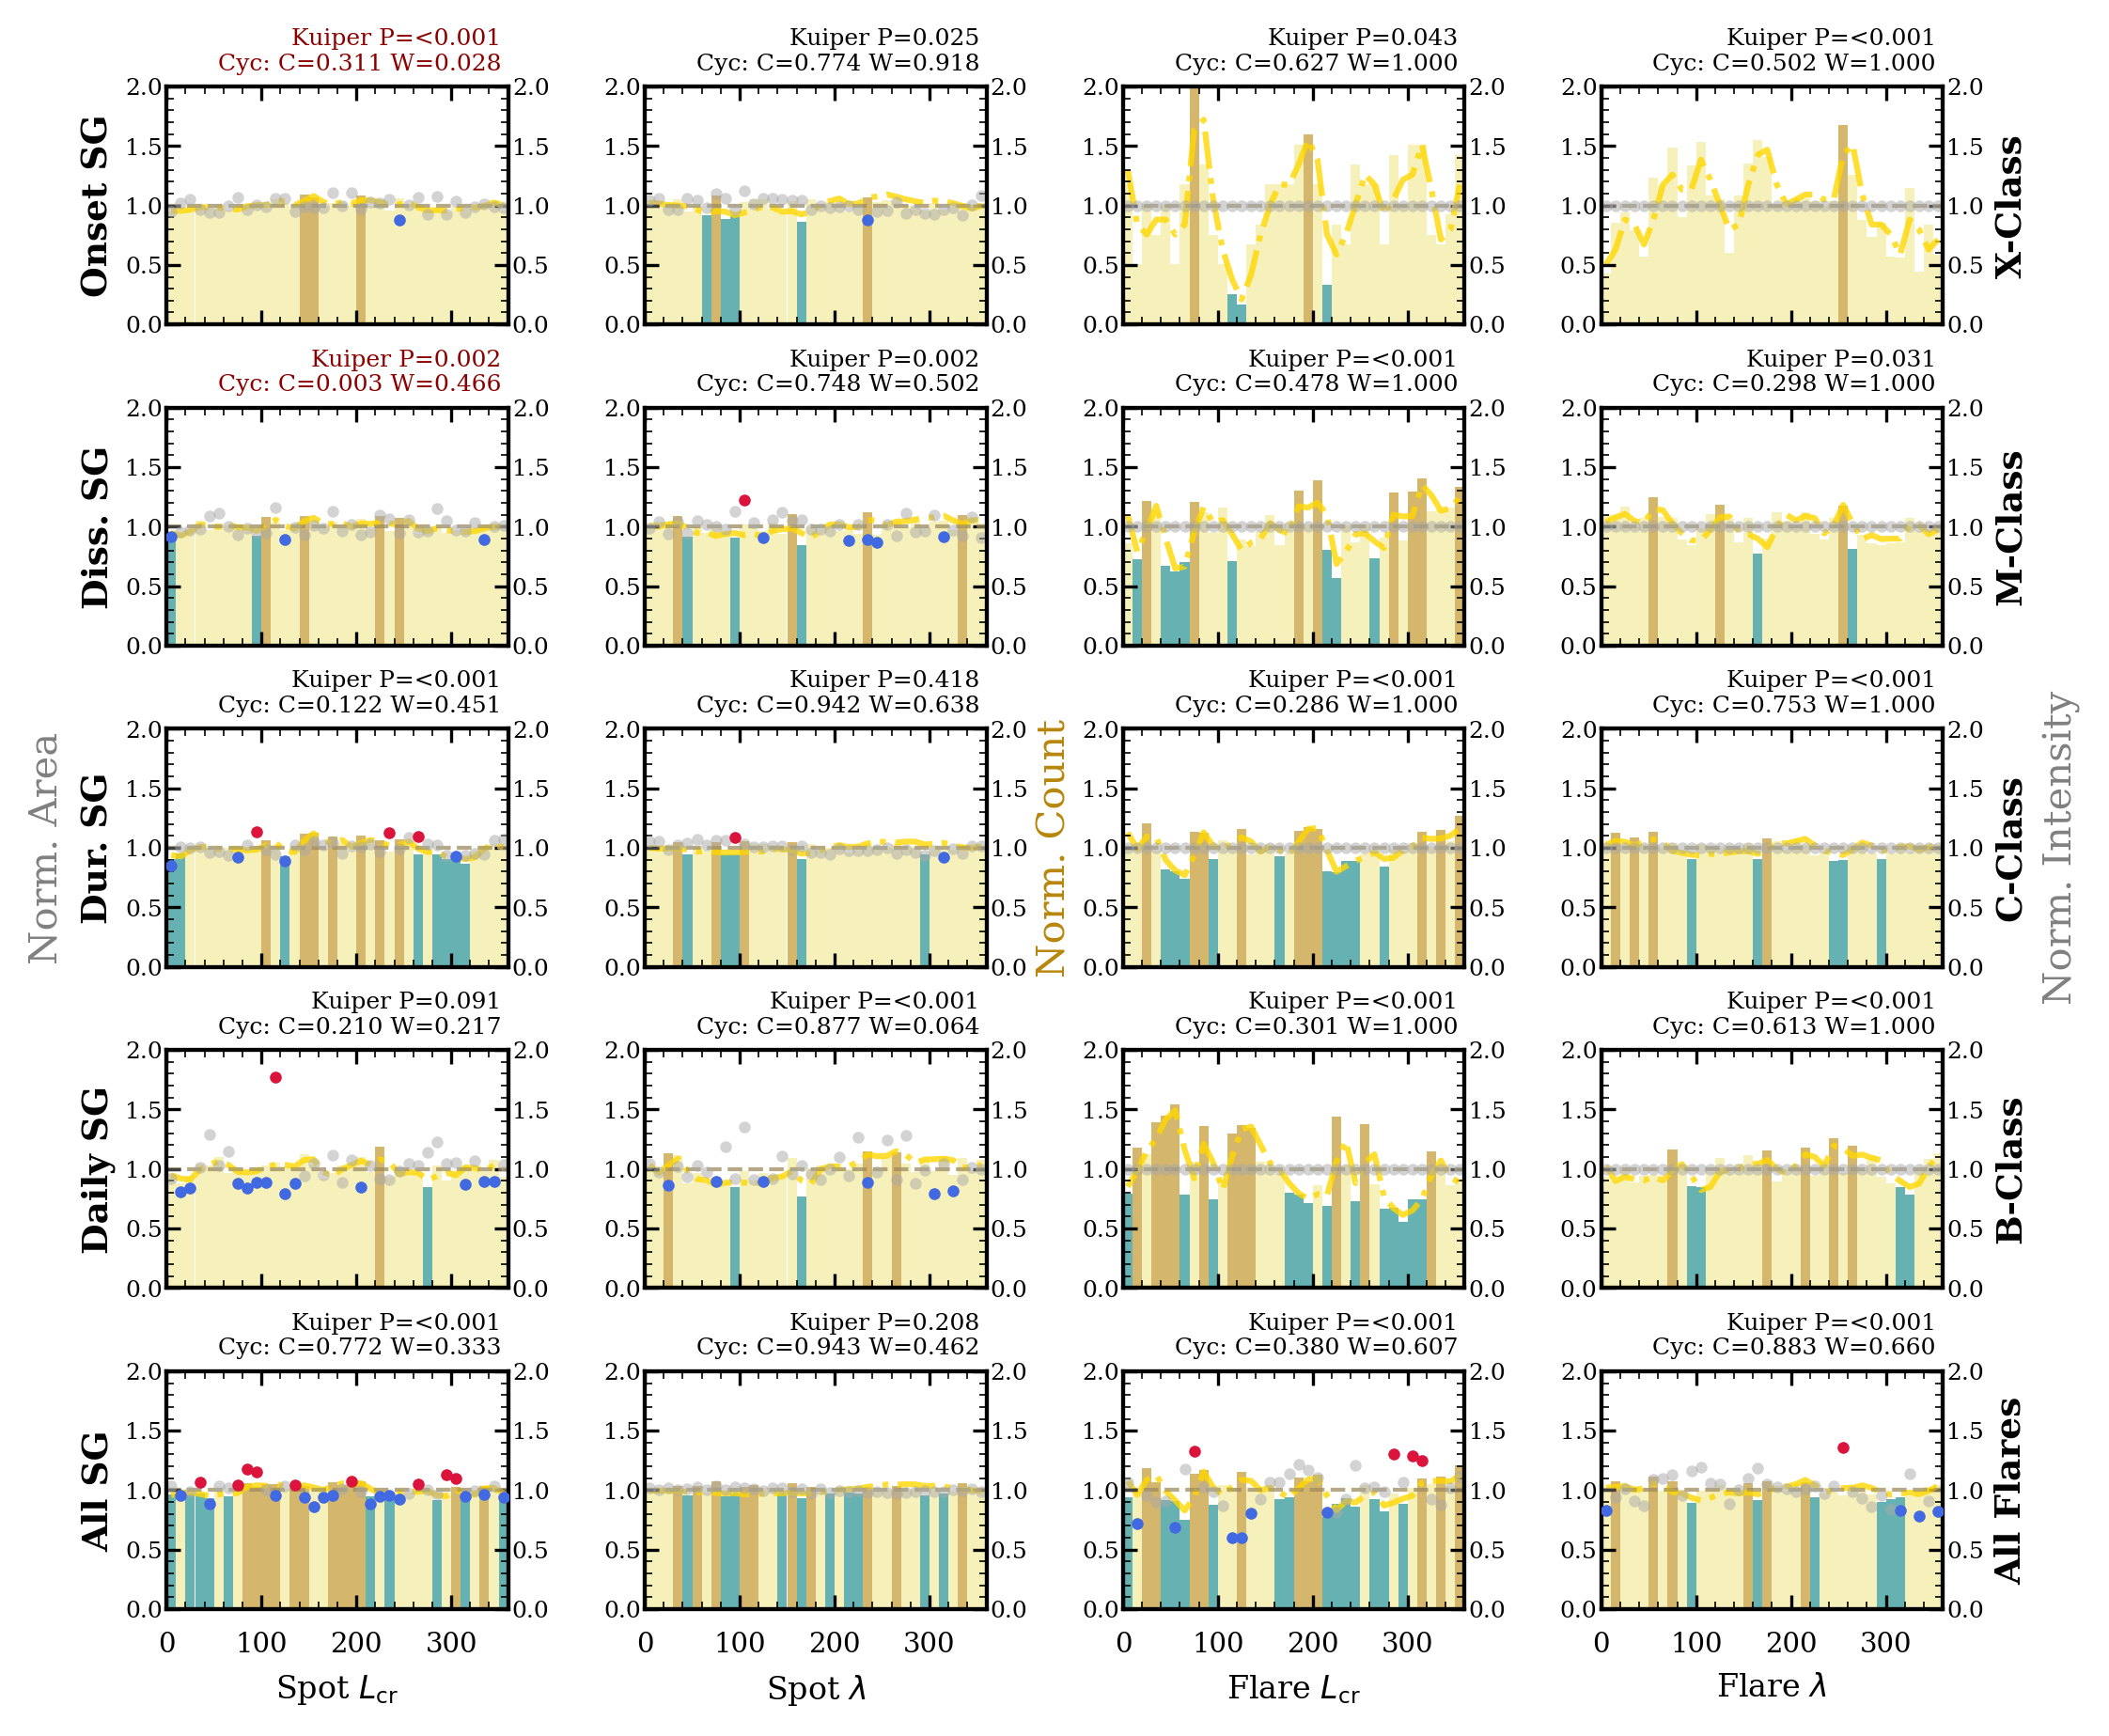

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from scipy import stats, interpolate
import warnings
from xlsxwriter.utility import xl_col_to_name 
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

# Ignore Pandas future version warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# 0. User Mode Settings
# ==============================================================================
# [Key Modification] Set all to False to restore visibility of "active longitudes"
# False = Intuitive Trend Mode (preserves autocorrelation/clustering signals, shows active longitudes)
ENABLE_STRICT_SIGMA_CORRECTION = False 
ENABLE_FDR_CORRECTION = False          

ECCENTRICITY_EARTH = 0.0167
PERIHELION_LON_EARTH = 282.9  
N_PERMS_GLOBAL = 10000

# ==============================================================================
# 1. Plot Style Settings
# ==============================================================================
def setup_astro_style():
    try:
        plt.style.use('seaborn-v0_8-paper')
    except:
        if 'seaborn-paper' in plt.style.available:
            plt.style.use('seaborn-paper')
        else:
            plt.style.use('default')
    
    plt.rcParams.update({
        'font.family': 'serif', 
        'axes.unicode_minus': False,
        'figure.dpi': 300, 
        'savefig.dpi': 300,
        'axes.linewidth': 1.0,
        'xtick.direction': 'in', 'ytick.direction': 'in',
        'xtick.top': True, 'ytick.right': True,
        'xtick.minor.visible': True, 'ytick.minor.visible': True
    })
setup_astro_style()

# ==============================================================================
# 2. Data Processing Helper Functions
# ==============================================================================
def convert_to_intensity(row):
    type_multiplier = {'A': 1, 'B': 10, 'C': 100, 'M': 1000, 'X': 10000}
    try:
        if 'xray_class' in row and not pd.isna(row['xray_class']):
            raw = str(row['xray_class']).strip().upper()
        else:
            return np.nan

        if len(raw) < 1: return np.nan
        flare_type = raw[0]
        if flare_type not in type_multiplier: return np.nan
        try: 
            level_val = float(raw[1:]) if len(raw) > 1 else 1.0
        except: 
            level_val = 1.0
        return type_multiplier[flare_type] * level_val
    except: return np.nan

# ==============================================================================
# [New/Modified] 2.1 Earth Position Weight Correction Module (JPL Ephemeris vs Theoretical)
# ==============================================================================
EARTH_DENSITY_FUNC = None  # Global interpolation function cache

def init_jpl_earth_weights(parquet_path):
    """
    Initialization function: Attempt to load JPL ephemeris data to build precise Earth position probability density.
    
    Principle:
    Read Earth's Heliocentric Ecliptic Longitude from 1849-2050,
    Calculate the actual proportion of time Earth spends in each longitude interval.
    This is more rigorous than the theoretical Kepler formula (~8% error), 
    automatically including perihelion precession and lunar perturbations.
    """
    global EARTH_DENSITY_FUNC
    
    # Check if file exists
    if not os.path.exists(parquet_path):
        print(f"--- [Info] JPL file not found: {parquet_path}")
        print("--- [Info] Fallback to Kepler theoretical formula (Approx. 8% deviation).")
        return False

    try:
        print(f"--- [Init] Loading JPL Ephemeris: {parquet_path} ---")
        df_jpl = pd.read_parquet(parquet_path)
        
        # 1. Get longitude data (assuming column name is '399_lon', unit is degrees)
        if '399_lon' not in df_jpl.columns:
            raise ValueError("Column '399_lon' not found in parquet.")
            
        lon_data = df_jpl['399_lon'].values
        
        # 2. Data cleaning and normalization
        lon_data = lon_data[~np.isnan(lon_data)]
        # Ensure 0-360 range
        lon_data = (lon_data + 360) % 360 

        # 3. Build high-resolution probability density (PDF)
        # bins=3600 (0.1 degree precision), density=True (integral area is 1)
        hist, bin_edges = np.histogram(lon_data, bins=3600, range=(0, 360), density=True)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        
        # 4. Cyclic boundary padding
        # To prevent interpolation distortion at the 0/360 degree boundary, copy a segment of data at both ends
        x_pad = np.concatenate(([bin_centers[-1]-360], bin_centers, [bin_centers[0]+360]))
        y_pad = np.concatenate(([hist[-1]], hist, [hist[0]]))
        
        # 5. Create global interpolation function
        EARTH_DENSITY_FUNC = interpolate.interp1d(x_pad, y_pad, kind='linear', fill_value="extrapolate")
        
        print("--- [Success] JPL Earth Weights Initialized (Rigorous Mode) ---")
        return True

    except Exception as e:
        print(f"!!! Error loading JPL data: {e}")
        print("!!! Fallback to Kepler theoretical formula.")
        return False

def get_theoretical_weights(bins, target_col_name):
    """
    Calculate theoretical weights for given bins.
    Prioritize using JPL real distribution (if loaded), otherwise fallback to Kepler approximation.
    """
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # 1. Determine if Earth perspective is involved (coordinate systems requiring correction)
    # Including: 'lon_eclip' (Ecliptic), 'hme_lon' (Heliocentric Mean Ecliptic), 'Lambda' (Apparent Longitude), etc.
    need_correction = any(x in target_col_name for x in ['eclip', 'hme', 'Lambda'])
    
    if need_correction:
        # [Option A] Use JPL real data (High precision)
        if EARTH_DENSITY_FUNC is not None:
            # Get probability density values
            pdf_values = EARTH_DENSITY_FUNC(bin_centers)
            # Normalization: Return relative weights such that sum(weights) = 1 (used for statistical expectation calculation)
            # Note: If bin widths are non-uniform, multiply by bin_width here; however, bins are typically uniform.
            return pdf_values / np.sum(pdf_values)

        # [Option B] Fallback to Kepler formula (Low precision, ~8% error)
        else:
            # Perihelion longitude (J2000 is approx. 282.9)
            anomaly_rad = np.radians(bin_centers - PERIHELION_LON_EARTH)
            # Residence time t ∝ 1 / (angular velocity) ∝ 1 / (1 + e*cos(f))^2
            angular_velocity = (1 + ECCENTRICITY_EARTH * np.cos(anomaly_rad))**2
            weights = 1.0 / angular_velocity
            return weights / np.sum(weights)
            
    else:
        # 2. Pure solar coordinates (e.g., Carrington, Stonyhurst)
        # Assume observations are uniform, no Earth orbit correction needed
        return np.ones(len(bin_centers)) / len(bin_centers)

# ==============================================================================
# 3. Core Statistical Module
# ==============================================================================

def calculate_circular_stats_corrected(data_array, low, high, target_col_name, is_periodic=True):
    if len(data_array) == 0: return np.nan, np.nan, "N/A"

    grid_bins = np.linspace(low, high, 2000)
    pdf_weights = get_theoretical_weights(grid_bins, target_col_name)
    cdf_vals = np.cumsum(pdf_weights)
    cdf_vals = cdf_vals / cdf_vals[-1] 
    
    grid_centers = 0.5 * (grid_bins[:-1] + grid_bins[1:])
    f_interp = interpolate.interp1d(grid_centers, cdf_vals, kind='linear', fill_value="extrapolate")
    transformed_data = f_interp(data_array)
    
    transformed_data = np.clip(transformed_data, 0, 1)
    transformed_data = np.sort(transformed_data)
    N = len(transformed_data)
    
    if is_periodic:
        D_plus = np.max((np.arange(1, N + 1) / N) - transformed_data)
        D_minus = np.max(transformed_data - (np.arange(0, N) / N))
        stat_val = D_plus + D_minus
        lam = (np.sqrt(N) + 0.155 + 0.24/np.sqrt(N)) * stat_val
        p_val = 0
        for j in range(1, 10):
            term = (4 * j**2 * lam**2 - 1) * np.exp(-2 * j**2 * lam**2)
            p_val += 2 * term
        p_val = max(0, min(1, p_val))
        test_name = "Kuiper"
    else:
        res = stats.kstest(transformed_data, 'uniform', args=(0, 1))
        stat_val = res.statistic
        p_val = res.pvalue
        test_name = "KS"

    return stat_val, p_val, test_name

def scan_statistics_sliding_window(df, target_col, area_col, stats_range, window_width=10, is_periodic=True):
    if df.empty: return pd.DataFrame()
    start, end, step = stats_range
    grid_bins = np.arange(start, end + step/1000.0, step) 
    
    counts, _ = np.histogram(df[target_col], bins=grid_bins)
    area_sums, _ = np.histogram(df[target_col], bins=grid_bins, weights=df[area_col])
    
    bin_centers = 0.5 * (grid_bins[:-1] + grid_bins[1:])
    window_size_bins = int(window_width / step)
    if window_size_bins < 1: window_size_bins = 1
    
    scan_counts = np.zeros_like(counts, dtype=float)
    scan_area_sums = np.zeros_like(area_sums, dtype=float)
    N = len(counts)
    half_win = window_size_bins // 2
    
    for i in range(N):
        if is_periodic:
            indices = np.arange(i - half_win, i - half_win + window_size_bins) % N
            current_win_len = window_size_bins
        else:
            raw_indices = np.arange(i - half_win, i - half_win + window_size_bins)
            indices = raw_indices[(raw_indices >= 0) & (raw_indices < N)]
            current_win_len = len(indices)
            
        if current_win_len > 0:
            scale = window_size_bins / current_win_len
            scan_counts[i] = np.sum(counts[indices]) * scale
            scan_area_sums[i] = np.sum(area_sums[indices]) * scale
    
    with np.errstate(divide='ignore', invalid='ignore'):
        scan_mean_area = np.divide(scan_area_sums, scan_counts, out=np.zeros_like(scan_counts), where=scan_counts!=0)
    
    global_mean_count = np.mean(counts) * window_size_bins
    global_mean_area = df[area_col].mean()
    scan_mean_area[scan_counts == 0] = np.nan

    return pd.DataFrame({
        'Bin_Center': bin_centers,
        'Scan_Norm_Count': scan_counts / (global_mean_count if global_mean_count > 0 else 1),
        'Scan_Norm_Area': scan_mean_area / (global_mean_area if global_mean_area > 0 else 1)
    })

def interval_statistics_with_fdr_unified(df, target_column, area_column, stats_range):
    if df.empty or target_column not in df.columns: return pd.DataFrame()

    df_copy = df[[target_column, area_column]].dropna().copy()
    if df_copy.empty: return pd.DataFrame()

    global_mean_area = df_copy[area_column].mean()
    start, end, interval = stats_range
    df_copy = df_copy[(df_copy[target_column] >= start) & (df_copy[target_column] <= end)]
    
    bins = np.arange(start, end + interval/1000.0, interval) 
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_weights = get_theoretical_weights(bins, target_column)

    df_copy['Interval'] = pd.cut(df_copy[target_column], bins=bins, right=True, include_lowest=True)
    
    agg_funcs = {'Count': (area_column, 'size'), 'Area_Sum': (area_column, 'sum'), 'Area_Std': (area_column, 'std')}
    try: grouped = df_copy.groupby('Interval', observed=False).agg(**agg_funcs)
    except: grouped = df_copy.groupby('Interval').agg(**agg_funcs)

    grouped = grouped.reindex(pd.cut([], bins=bins, right=True, include_lowest=True).categories, fill_value=0)
    grouped['Bin_Center'] = bin_centers
    total_events = grouped['Count'].sum()
    grouped['Expected_Count'] = total_events * bin_weights
    grouped['Norm_Count'] = grouped['Count'] / grouped['Expected_Count'].replace(0, 1)

    # 1. Calculate theoretical over-dispersion factor (for reference only, does not affect plotting)
    with np.errstate(divide='ignore', invalid='ignore'):
        chi_terms = (grouped['Count'] - grouped['Expected_Count'])**2 / grouped['Expected_Count']
        chi_terms = chi_terms.replace([np.inf, -np.inf], np.nan).fillna(0)
    chi_squared_stat = chi_terms.sum()
    dof = len(grouped) - 1
    calculated_scale = np.sqrt(chi_squared_stat / dof) if dof > 0 else 1.0
    true_inflation_factor = max(1.0, calculated_scale)

    # 2. Decide whether to apply this factor in Z-Score calculation
    if ENABLE_STRICT_SIGMA_CORRECTION:
        applied_factor = true_inflation_factor
    else:
        # [Modification] Force not to inflate error, restore original data fluctuation
        applied_factor = 1.0  

    with np.errstate(divide='ignore', invalid='ignore'):
        grouped['Mean_Area'] = grouped['Area_Sum'].divide(grouped['Count'])
        # Standard error
        grouped['Mean_Area_SEM'] = (grouped['Area_Std'].divide(np.sqrt(grouped['Count']))) * applied_factor
        
        # Z-score Count
        sigma_numerator = grouped['Count'] - grouped['Expected_Count']
        sigma_denominator = np.sqrt(grouped['Expected_Count']) * applied_factor
        grouped['Sigma_Count'] = sigma_numerator / sigma_denominator
        grouped['Sigma_Count'] = grouped['Sigma_Count'].replace([np.inf, -np.inf], 0).fillna(0)
    
    grouped['P_Value_Count'] = 2 * stats.norm.sf(np.abs(grouped['Sigma_Count'].values))

    grouped['Norm_Mean_Area'] = grouped['Mean_Area'].divide(global_mean_area)
    with np.errstate(divide='ignore', invalid='ignore'):
        grouped['Sigma_Area'] = (grouped['Mean_Area'] - global_mean_area) / grouped['Mean_Area_SEM']
        grouped['Sigma_Area'] = grouped['Sigma_Area'].replace([np.inf, -np.inf], 0).fillna(0)
    
    grouped['P_Value_Area'] = 2 * stats.norm.sf(np.abs(grouped['Sigma_Area'].values))

    # 3. Significance marking (based on settings)
    def apply_sig_mask(p_vals, mask=None):
        if mask is None: mask = np.ones_like(p_vals, dtype=bool)
        if not mask.any(): return np.zeros_like(p_vals, dtype=bool)
        
        if ENABLE_FDR_CORRECTION:
            # FDR (Benjamini-Hochberg)
            valid_p = p_vals[mask]
            m = len(valid_p)
            if m == 0: return np.zeros_like(p_vals, dtype=bool)
            sorted_indices = np.argsort(valid_p)
            sorted_p = valid_p[sorted_indices]
            threshold = (np.arange(1, m + 1) / m) * 0.05
            is_sig = sorted_p <= threshold
            result_mask = np.zeros_like(p_vals, dtype=bool)
            if np.any(is_sig):
                crit_idx = np.max(np.where(is_sig)[0])
                crit_p = sorted_p[crit_idx]
                result_mask[mask] = (valid_p <= crit_p)
            return result_mask
        else:
            # [Modification] Simple P < 0.05 (corresponding to Z > 1.96)
            result_mask = np.zeros_like(p_vals, dtype=bool)
            result_mask[mask] = (p_vals[mask] < 0.05)
            return result_mask

    mask_valid_area = grouped['Count'] > 1 
    grouped['Is_FDR_Sig_Area'] = apply_sig_mask(grouped['P_Value_Area'].values, mask_valid_area)
    grouped['Is_FDR_Sig_Count'] = apply_sig_mask(grouped['P_Value_Count'].values)
    
    # Record true factor for reference
    grouped['Dynamic_Sigma_Factor'] = true_inflation_factor

    return grouped.reset_index()

def calculate_dual_p_values(df, target_col, area_col, stats_range, is_periodic=True, n_perms=2000):
    """Dual permutation test (logic unchanged, for global significance reference)"""
    data = df[[target_col, area_col]].dropna()
    start, end, interval = stats_range
    data = data[(data[target_col] >= start) & (data[target_col] <= end)]
    
    if data.empty: return (np.nan, np.nan), (np.nan, np.nan)
    
    x = data[target_col].values
    y = data[area_col].values
    global_mean_area = np.mean(y)
    bins = np.arange(start, end + interval/1000.0, interval)
    n_bins = len(bins) - 1
    x_range = end - start
    bin_weights = get_theoretical_weights(bins, target_col)
    cdf_weights = np.cumsum(bin_weights) / np.sum(bin_weights)

    def sample_from_background(n_samples):
        u = np.random.rand(n_samples)
        bin_indices = np.searchsorted(cdf_weights, u)
        bin_indices = np.clip(bin_indices, 0, n_bins - 1)
        return bins[bin_indices] + np.random.rand(n_samples) * (bins[1] - bins[0])

    def get_stats_fast(x_arr, y_arr, weights_arr):
        indices = np.digitize(x_arr, bins)
        indices[indices == len(bins)] = len(bins) - 1 
        valid_mask = (indices > 0) & (indices <= n_bins)
        valid_idx = indices[valid_mask] - 1
        
        counts = np.bincount(valid_idx, minlength=n_bins)
        expected = len(x_arr) * weights_arr
        
        with np.errstate(divide='ignore', invalid='ignore'):
            chi_terms = (counts - expected)**2 / expected
            chi_terms[expected == 0] = 0 
            stat_count = np.sum(chi_terms)
        
        valid_y = y_arr[valid_mask]
        sums = np.bincount(valid_idx, weights=valid_y, minlength=n_bins)
        sum_sq = np.bincount(valid_idx, weights=valid_y**2, minlength=n_bins)
        
        with np.errstate(divide='ignore', invalid='ignore'):
            means = sums / counts
            variances = (sum_sq - (sums**2)/counts) / (counts - 1)
            sems = np.sqrt(variances) / np.sqrt(counts)
            sigmas = (means - global_mean_area) / sems
            sigmas = np.nan_to_num(sigmas, nan=0.0)
            sigmas = np.clip(sigmas, -100, 100)
            
        stat_area = np.sum(sigmas**2)
        return stat_count, stat_area

    obs_count_stat, obs_area_stat = get_stats_fast(x, y, bin_weights)
    
    c_count_std = 0; c_area_std = 0
    c_count_cyc = 0; c_area_cyc = 0
    y_perm = y.copy()
    
    for _ in range(n_perms):
        np.random.shuffle(y_perm)
        _, s_a = get_stats_fast(x, y_perm, bin_weights)
        if s_a >= obs_area_stat: c_area_std += 1
        x_rand_bg = sample_from_background(len(x))
        s_c, _ = get_stats_fast(x_rand_bg, y, bin_weights)
        if s_c >= obs_count_stat: c_count_std += 1
        if is_periodic:
            shift = np.random.uniform(0, x_range)
            x_shifted = (x + shift - start) % x_range + start
            s_c_cyc, s_a_cyc = get_stats_fast(x_shifted, y, bin_weights)
            if s_c_cyc >= obs_count_stat: c_count_cyc += 1
            if s_a_cyc >= obs_area_stat: c_area_cyc += 1

    p_cnt_std = (c_count_std + 1) / (n_perms + 1)
    p_area_std = (c_area_std + 1) / (n_perms + 1)
    p_cnt_cyc = (c_count_cyc + 1) / (n_perms + 1) if is_periodic else np.nan
    p_area_cyc = (c_area_cyc + 1) / (n_perms + 1) if is_periodic else np.nan
    return (p_cnt_std, p_cnt_cyc), (p_area_std, p_area_cyc)


# ==============================================================================
# 4. Main Program (Refactored: Parallel Comparison Mode)
# ==============================================================================

base_path = '../../data/ready/' 
output_dir = '../../results/02_carr_vs_eclip_dist/'
os.makedirs(output_dir, exist_ok=True)

# Initialize high-precision Earth model
jpl_parquet_path = f'{base_path}781_planets_dwarfs_asteroids_lonlat.parquet'
init_jpl_earth_weights(jpl_parquet_path)

# ------------------------------------------------------------------------------
# 4.1 Configuration Definition
# ------------------------------------------------------------------------------

# [Spot] Left 5 rows: Sunspot phases
spot_row_configs = [
    {'key': 'onset', 'label': 'Onset SG'},
    {'key': 'diss',  'label': 'Diss. SG'},
    {'key': 'dur',   'label': 'Dur. SG'},
    {'key': 'daily', 'label': 'Daily SG'},
    {'key': 'all',   'label': 'All SG'}
]

# [Flare] Right 5 rows: Flare classes (using Lambda for dynamic filtering)
flare_row_configs = [
    {'filter': lambda df: df[df['xray_class'].astype(str).str.startswith('X')], 'label': 'X-Class', 'key': 'x_class'},
    {'filter': lambda df: df[df['xray_class'].astype(str).str.startswith('M')], 'label': 'M-Class', 'key': 'm_class'},
    {'filter': lambda df: df[df['xray_class'].astype(str).str.startswith('C')], 'label': 'C-Class', 'key': 'c_class'},
    {'filter': lambda df: df[df['xray_class'].astype(str).str.startswith('B')], 'label': 'B-Class', 'key': 'b_class'},
    {'filter': lambda df: df,                                                   'label': 'All Flares', 'key': 'all_flares'}
]

# [Column] 4 column definitions
# Col 0, 1: Spot (Area as Weight)
# Col 2, 3: Flare (Intensity as Weight)
col_configs = [
    # --- Spot Block ---
    {'type': 'spot',  'col': 'hcc_lon', 'label': r'Spot $L_{\mathrm{cr}}$', 'range': [0, 360, 10]},
    {'type': 'spot',  'col': 'hme_lon', 'label': r'Spot $\lambda$',        'range': [0, 360, 10]},
    # --- Flare Block ---
    {'type': 'flare', 'col': 'hgc_lon', 'label': r'Flare $L_{\mathrm{cr}}$', 'range': [0, 360, 10]},
    {'type': 'flare', 'col': 'hme_lon', 'label': r'Flare $\lambda$',        'range': [0, 360, 10]}
]

# ------------------------------------------------------------------------------
# 4.2 Data Loading
# ------------------------------------------------------------------------------

dfs_spot = {}
try:
    for cfg in spot_row_configs:
        file_path = f'{base_path}sg_1874_2025_{cfg["key"]}.csv'
        if os.path.exists(file_path):
            try: temp_df = pd.read_csv(file_path)
            except: temp_df = pd.read_csv(file_path, encoding='gbk')
            dfs_spot[cfg['key']] = temp_df
    print(f"--- Sunspot Data loaded: {len(dfs_spot)} datasets ---")
except Exception as e:
    print(f"!!! Spot loading error: {e}"); sys.exit()

FLARE_DATA_FILE = f'{base_path}flare_1975_2017.csv'
df_flare_base = pd.DataFrame()
try:
    if os.path.exists(FLARE_DATA_FILE):
        try: df_raw = pd.read_csv(FLARE_DATA_FILE)
        except: df_raw = pd.read_csv(FLARE_DATA_FILE, encoding='gbk')
        # [Fix] Added .copy() to avoid SettingWithCopyWarning
        df_raw.dropna(subset=['xray_class'], inplace=True)
        df_raw = df_raw.copy()
        # Even if xray_intensity column exists, keep original calculation logic for consistent flux grading
        df_raw['intensity'] = df_raw.apply(convert_to_intensity, axis=1)
        df_raw.dropna(subset=['intensity'], inplace=True)
        df_flare_base = df_raw
        print(f"--- Flare Base Data loaded: {len(df_flare_base)} records ---")
except Exception as e:
    print(f"!!! Flare processing error: {e}")

excel_data_collection = {} 

# ------------------------------------------------------------------------------
# 4.3 Plot Initialization
# ------------------------------------------------------------------------------

# [Key Modification] Size (7, 6) fits journal full page width, increased wspace to separate left and right blocks
fig, axes = plt.subplots(5, 4, figsize=(7, 6), sharex='col', sharey=False)
plt.subplots_adjust(left=0.05, right=0.95, top=0.96, bottom=0.06, hspace=0.35, wspace=0.4)

print('\n--- Running Analysis (Parallel Comparison Mode) ---')

# ------------------------------------------------------------------------------
# 4.4 Loop Processing
# ------------------------------------------------------------------------------

for row_idx in range(5):
    # Get current row configuration
    spot_cfg = spot_row_configs[row_idx]
    flare_cfg = flare_row_configs[row_idx]
    
    print(f">> Row {row_idx+1}: Spot=[{spot_cfg['label']}] vs Flare=[{flare_cfg['label']}]")

    # Prepare current row datasets
    # Spot Data
    df_spot_curr = dfs_spot.get(spot_cfg['key'], pd.DataFrame())
    # Flare Data (Apply Filter)
    df_flare_curr = pd.DataFrame()
    if not df_flare_base.empty:
        try:
            df_flare_curr = flare_cfg['filter'](df_flare_base)
        except Exception as e:
            print(f"   Filter error: {e}")

    # Iterate through 4 columns
    for col_idx, col_cfg in enumerate(col_configs):
        ax = axes[row_idx, col_idx]
        
        # Determine data source for current column
        if col_cfg['type'] == 'spot':
            target_df = df_spot_curr
            weight_col = 'area'
            current_label = spot_cfg['label']
            file_key = spot_cfg['key']
        else:
            target_df = df_flare_curr
            weight_col = 'intensity'
            current_label = flare_cfg['label']
            file_key = flare_cfg['key']
        
        target_col = col_cfg['col']
        
        # Handle empty data
        if target_df.empty or target_col not in target_df.columns or len(target_df) < 5:
            ax.axis('off')
            continue

        stats_range = col_cfg['range']
        is_periodic = True
        
        # 1. Statistical calculation
        # Visual Mode: Sigma=1.0, No FDR applied to standard errors, but calculated for Excel
        stats_df = interval_statistics_with_fdr_unified(target_df, target_col, weight_col, stats_range)
        scan_df = scan_statistics_sliding_window(target_df, target_col, weight_col, stats_range, window_width=20, is_periodic=is_periodic)

        # 2. Global test (Kuiper)
        raw_vals = target_df[target_col].dropna().values
        raw_vals = raw_vals[(raw_vals >= stats_range[0]) & (raw_vals <= stats_range[1])]
        k_stat, k_p, test_type = calculate_circular_stats_corrected(raw_vals, stats_range[0], stats_range[1], target_col, is_periodic)

        # 3. Permutation test (calculate P_Count, P_Weight)
        (p_cnt_std, p_cnt_cyc), (p_wgt_std, p_wgt_cyc) = calculate_dual_p_values(
            target_df, target_col, weight_col, stats_range, is_periodic, n_perms=N_PERMS_GLOBAL
        )

        # 4. Save data to Excel collection
        if not stats_df.empty:
            coord_name = 'L_cr' if 'hcc' in target_col or 'hgc' in target_col else 'Lambda'
            # Sheet Name: Type_Stage_Coord
            sheet_name = f"{col_cfg['type'].capitalize()}_{file_key}_{coord_name}"[:31]
            
            save_df = stats_df.copy()
            if not scan_df.empty:
                save_df = pd.merge(save_df, scan_df[['Bin_Center', 'Scan_Norm_Count', 'Scan_Norm_Area']], on='Bin_Center', how='left')
            
            # Rename Flare columns to distinguish Intensity
            if col_cfg['type'] == 'flare':
                rename_map = {
                    'Mean_Area': 'Mean_Intensity', 'Norm_Mean_Area': 'Norm_Mean_Intensity',
                    'Sigma_Area': 'Sigma_Intensity', 'Mean_Area_SEM': 'Mean_Intensity_SEM',
                    'Is_FDR_Sig_Area': 'Is_FDR_Sig_Intensity', 'P_Value_Area': 'P_Value_Intensity',
                    'Scan_Norm_Area': 'Scan_Norm_Intensity'
                }
                save_df.rename(columns=rename_map, inplace=True)

            save_df['Global_Kuiper_P'] = k_p
            save_df['Global_Perm_P_Cnt_Cyc'] = p_cnt_cyc
            save_df['Global_Perm_P_Wgt_Cyc'] = p_wgt_cyc
            
            excel_data_collection[sheet_name] = save_df

        # 5. Plotting (dual axis)
        if stats_df.empty: 
            ax.axis('off'); continue

        ax.set_xlim(stats_range[0], stats_range[1])
        
        # Only show X axis label on last row
        if row_idx == 4: 
            ax.set_xlabel(col_cfg['label'], fontsize=8)

        # Right Axis (Count)
        ax2 = ax.twinx()
        ax.patch.set_visible(False)
        ax.set_zorder(ax2.get_zorder() + 1)
        ax.grid(False); ax2.grid(False)

        # Count Bars
        ax2.axhline(1, color='goldenrod', ls='--', lw=1, alpha=0.5)
        # Color logic: highlight significant Count peaks
        bar_colors = []
        for _, r in stats_df.iterrows():
            if r['Is_FDR_Sig_Count']:
                bar_colors.append('darkgoldenrod' if r['Sigma_Count'] > 0 else 'teal')
            else:
                bar_colors.append('khaki')
        
        ax2.bar(stats_df['Bin_Center'], stats_df['Norm_Count'], width=stats_range[2], color=bar_colors, alpha=0.6)
        
        # Sliding Window Line
        if not scan_df.empty:
            ax2.plot(scan_df['Bin_Center'], scan_df['Scan_Norm_Count'], color='gold', ls='-.', lw=1.5, alpha=0.8)

        # Left Axis (Weight: Area/Intensity)
        ax.axhline(1, color='gray', ls='--', lw=1, alpha=0.5)
        ax.plot(stats_df['Bin_Center'], stats_df['Norm_Mean_Area'], 'o', color='darkgray', ms=3, alpha=0.5)
        
        # Note: X/Y axis data for plotting must be aligned. stats_df is not renamed, so continue using generic column names
        sig_mask = stats_df['Is_FDR_Sig_Area'] # Generic name
        sigma_vals = stats_df['Sigma_Area']    # Generic name
        
        high_mask = sigma_vals > 0
        if sig_mask.any():
            # Pos (Red)
            ax.plot(stats_df.loc[sig_mask & high_mask, 'Bin_Center'], 
                    stats_df.loc[sig_mask & high_mask, 'Norm_Mean_Area'], 
                    'o', color='crimson', ms=3, zorder=10)
            # Neg (Blue)
            ax.plot(stats_df.loc[sig_mask & ~high_mask, 'Bin_Center'], 
                    stats_df.loc[sig_mask & ~high_mask, 'Norm_Mean_Area'], 
                    'o', color='royalblue', ms=3, zorder=10)

        # Y-Axis Formatting
        # Weight Axis (Left)
        y_max_wgt = stats_df['Norm_Mean_Area'].max()
        limit_wgt = 2.0 # if y_max_wgt < 1.6 else y_max_wgt * 1.2
        ax.set_ylim(0, limit_wgt)
        
        # Count Axis (Right)
        y_max_cnt = stats_df['Norm_Count'].max()
        limit_cnt = 2.0 # if y_max_cnt < 1.6 else y_max_cnt * 1.2
        ax2.set_ylim(0, limit_cnt)

        # Ticks styling
        for axis_obj in [ax, ax2]:
            axis_obj.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            axis_obj.yaxis.set_major_locator(MaxNLocator(nbins=4, min_n_ticks=4))
            axis_obj.tick_params(axis='y', labelsize=6, pad=1)
            axis_obj.tick_params(axis='x', labelsize=7)

  
        # ----------------------------------------------------------------------
        # P-Value Display (back to initial approach: upper right double line, color entire text)
        # ----------------------------------------------------------------------
        def smart_p(p): return "N/A" if np.isnan(p) else ("<0.001" if p < 0.001 else f"{p:.3f}")
        
        # Determine significance color: if either C or W is < 0.05, entire text is displayed in dark red
        is_sig = False
        if (not np.isnan(p_cnt_cyc) and p_cnt_cyc < 0.05): is_sig = True
        if (not np.isnan(p_wgt_cyc) and p_wgt_cyc < 0.05): is_sig = True
        
        info_col = 'darkred' if is_sig else 'black'
        
        # Text content: first line global test, second line cyclic test (C=Count, W=Weight)
        p_text = f"{test_type} P={smart_p(k_p)}\nCyc: C={smart_p(p_cnt_cyc)} W={smart_p(p_wgt_cyc)}"
        
        # Plot: upper right corner (0.98, 1.05)
        ax.text(0.98, 1.05, p_text, transform=ax.transAxes, 
                ha='right', va='bottom', fontsize=6, color=info_col)

        # ----------------------------------------------------------------------
        # Labels and Text (Refactored: Axis Titles on Row 3 only, Types on All Rows)
        # ----------------------------------------------------------------------
        
        # Column 1 (Spot Col 0): left region
        if col_idx == 0:
            # 1. Spot type (Row Label): every row, placed inside
            ax.text(-0.20, 0.5, current_label, transform=ax.transAxes, 
                    va='center', ha='center', rotation='vertical', 
                    fontsize=9, fontweight='bold', color='black')
            
            # 2. Norm. Area (Axis Title): only on row 3, placed outermost
            if row_idx == 2:
                ax.text(-0.35, 0.5, 'Norm. Area', transform=ax.transAxes, 
                        va='center', ha='center', rotation='vertical', 
                        fontsize=10, color='gray', fontweight='normal')

        # Column 3 (Flare Col 2): middle region (between Spot and Flare)
        if col_idx == 2:
            # Norm. Count: only on row 3, as separator title between two blocks
            if row_idx == 2:
                ax.text(-0.20, 0.5, 'Norm. Count', transform=ax.transAxes,
                        va='center', ha='center', rotation='vertical', 
                        fontsize=10, color='darkgoldenrod', fontweight='normal')
        
        # Column 4 (Flare Col 3): right region
        if col_idx == 3:
            # 1. Flare type (Row Label): every row, placed inside (close to right axis)
            ax.text(1.20, 0.5, current_label, transform=ax.transAxes,
                    va='center', ha='center', rotation='vertical', 
                    fontsize=9, fontweight='bold', color='black')
            
            # 2. Norm. Intensity (Axis Title): only on row 3, placed outermost
            if row_idx == 2:
                ax.text(1.35, 0.5, 'Norm. Intensity', transform=ax.transAxes,
                        va='center', ha='center', rotation='vertical', 
                        fontsize=10, color='gray', fontweight='normal')
                
plt.savefig(f'{output_dir}Fig01_Spot_Flare_Longitude.eps', format='eps', bbox_inches='tight')


# ------------------------------------------------------------------------------
# 4.5 Save Excel
# ------------------------------------------------------------------------------
with pd.ExcelWriter(f'{output_dir}Fig01_Spot_Flare_Longitude_Source.xlsx', engine='xlsxwriter') as writer:
    workbook = writer.book
    sci_fmt = workbook.add_format({'num_format': '0.00E+00'})
    fdr_pos_fmt = workbook.add_format({'bg_color': '#FFC7CE', 'font_color': '#9C0006'})
    fdr_neg_fmt = workbook.add_format({'bg_color': '#C6EFCE', 'font_color': '#006100'})
    
    # Sort by key name to keep tidy
    for sn in sorted(excel_data_collection.keys()):
        df = excel_data_collection[sn]
        df.to_excel(writer, sheet_name=sn, index=False)
        ws = writer.sheets[sn]
        ws.set_column(0, df.shape[1] - 1, 13, sci_fmt)
        
        # Conditional formatting (supports both Area and Intensity)
        cols_to_check = [
            ('Sigma_Area', 'Is_FDR_Sig_Area'), 
            ('Sigma_Intensity', 'Is_FDR_Sig_Intensity'),
            ('Sigma_Count', 'Is_FDR_Sig_Count')
        ]
        
        for col, flag in cols_to_check:
            if col in df.columns and flag in df.columns:
                c_idx = df.columns.get_loc(col)
                f_idx = df.columns.get_loc(flag)
                col_letter = xl_col_to_name(f_idx)
                col_sigma_letter = xl_col_to_name(c_idx)
    
                ws.conditional_format(1, c_idx, df.shape[0], c_idx,
                    {'type': 'formula', 'criteria': f'=AND(${col_letter}2=TRUE, ${col_sigma_letter}2>0)', 'format': fdr_pos_fmt})
                ws.conditional_format(1, c_idx, df.shape[0], c_idx,
                    {'type': 'formula', 'criteria': f'=AND(${col_letter}2=TRUE, ${col_sigma_letter}2<0)', 'format': fdr_neg_fmt})

print("\n--- Done. Visual Mode Plot & Excel Generated. ---")

## Read XLSX

In [2]:
import pandas as pd
import numpy as np
import os
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Set file path (Make sure this matches your generation script output)
file_path = '../../results/02_carr_vs_eclip_dist/Fig01_Spot_Flare_Longitude_Source.xlsx'

def format_p(p):
    """Format P-value, highlighting significant values"""
    if pd.isna(p): return "N/A"
    # Ensure p is treated as float
    try: p = float(p)
    except: return str(p)
    
    str_p = "<0.001" if p < 0.001 else f"{p:.4f}"
    if p < 0.05:
        return f"{str_p} (*)"
    return str_p

def get_col_name(df, candidates):
    """Helper to find which column exists in the dataframe from a list of candidates"""
    for col in candidates:
        if col in df.columns:
            return col
    return None

def check_excel_results():
    if not os.path.exists(file_path):
        print(f"Error: File not found {file_path}")
        return

    print(f"=== Reading and analyzing: {file_path} ===\n")
    
    try:
        all_sheets = pd.read_excel(file_path, sheet_name=None)
    except Exception as e:
        print(f"Failed to read Excel: {e}")
        return

    for sheet_name, df in all_sheets.items():
        if df.empty: continue

        # ---------------------------------------------------------
        # 0. Detect Data Type (Spot/Area or Flare/Intensity)
        # ---------------------------------------------------------
        # Try to find the Weight/Intensity column names
        col_sigma_wgt = get_col_name(df, ['Sigma_Area', 'Sigma_Intensity'])
        col_sig_flag_wgt = get_col_name(df, ['Is_FDR_Sig_Area', 'Is_FDR_Sig_Intensity'])
        col_norm_wgt = get_col_name(df, ['Norm_Mean_Area', 'Norm_Mean_Intensity'])
        col_raw_wgt = get_col_name(df, ['Mean_Area', 'Mean_Intensity'])
        
        # Label for display
        wgt_label = "Intensity" if "Intensity" in (col_sigma_wgt or "") else "Area"

        # ---------------------------------------------------------
        # 1. Global statistics
        # ---------------------------------------------------------
        row0 = df.iloc[0]
        
        # Retrieve Global P-values (New code uses 'Wgt', old used 'Area')
        # Priority: Wgt (New) -> Int -> Area (Old fallback)
        p_wgt_cyc = row0.get('Global_Perm_P_Wgt_Cyc', row0.get('Global_Perm_P_Int_Cyc', row0.get('Global_Perm_P_Area_Cyc', np.nan)))
        p_cnt_cyc = row0.get('Global_Perm_P_Cnt_Cyc', np.nan)
        
        # Significance Check
        is_significant = False
        try:
            if (not pd.isna(p_wgt_cyc) and float(p_wgt_cyc) < 0.05): is_significant = True
            if (not pd.isna(p_cnt_cyc) and float(p_cnt_cyc) < 0.05): is_significant = True
        except: pass
   
        status_symbol = "✅ SIGNAL DETECTED" if is_significant else "❌ NO SIGNAL"
        header_deco = "★" * 5 if is_significant else "=" * 5

        print(f"\n{header_deco} Sheet: {sheet_name} ({wgt_label} Mode) [{status_symbol}] {header_deco}")
        
        print("[1. Global Stats & Config]")
        
        # Inflation Factor
        inflation = row0.get('Sigma_Inflation_Factor', row0.get('Dynamic_Sigma_Factor', 1.0))
        print(f"  > Sigma Inflation: {inflation:.2f} (Dynamic Correction)")

        k_stat = row0.get('Global_Kuiper_Stat', np.nan)
        k_p = row0.get('Global_Kuiper_P', np.nan)
        print(f"  > Kuiper Test (Uniformity): Stat={k_stat:.4f}, P={format_p(k_p)}")

        print(f"  > Cyclic Permutation (Gold Standard - Red Noise Corrected):")
        print(f"    - Weight ({wgt_label}) P: {format_p(p_wgt_cyc)}")
        print(f"    - Count P:              {format_p(p_cnt_cyc)}")
        
        print("-" * 50)

        # ---------------------------------------------------------
        # 2. Local significant intervals
        # ---------------------------------------------------------
        # Get significant rows
        sig_wgt = pd.DataFrame()
        if col_sig_flag_wgt:
            sig_wgt = df[df[col_sig_flag_wgt] == True]
            
        sig_count = pd.DataFrame()
        if 'Is_FDR_Sig_Count' in df.columns:
            sig_count = df[df['Is_FDR_Sig_Count'] == True]
        
        if not is_significant and sig_wgt.empty and sig_count.empty:
            print("  -> No statistically significant features found in this dataset.")
            continue

        print("[2. Local Significant Intervals (FDR Corrected)]")
        if sig_wgt.empty and sig_count.empty:
            print("  (No local FDR significant points)")
        else:
            if not sig_wgt.empty:
                print(f"  > Sig. {wgt_label} (Bins): {sig_wgt['Bin_Center'].tolist()}")
            if not sig_count.empty:
                print(f"  > Sig. Count (Bins):    {sig_count['Bin_Center'].tolist()}")

        # ---------------------------------------------------------
        # 3. Detailed strong anomalies
        # ---------------------------------------------------------
        print("-" * 50)
        # Filter: FDR significant AND |Sigma| > 3
        anom_wgt = pd.DataFrame()
        if not sig_wgt.empty and col_sigma_wgt:
            anom_wgt = sig_wgt[sig_wgt[col_sigma_wgt].abs() > 3].copy()
            
        anom_count = pd.DataFrame()
        if not sig_count.empty and 'Sigma_Count' in df.columns:
            anom_count = sig_count[sig_count['Sigma_Count'].abs() > 3].copy()
            
        if anom_wgt.empty and anom_count.empty:
             print("[3. Strong Anomaly Details] (No strong anomalies with |Sigma| > 3)")
        else:
            print(f"[3. Strong Anomaly Details (|σ| > 3 & FDR = True)]")
            
            # --- A. Weight (Area/Intensity) Anomalies ---
            if not anom_wgt.empty:
                anom_wgt = anom_wgt.sort_values(col_sigma_wgt, key=abs, ascending=False)
                print(f"\n  [{wgt_label} Anomalies] (Sorted by Sigma):")
                print(f"  {'Bin':<8} {'Sigma':<10} {'Norm_Val':<12} {'Raw_Val':<10}")
                for _, r in anom_wgt.iterrows():
                    norm_val = r.get(col_norm_wgt, np.nan)
                    raw_val = r.get(col_raw_wgt, np.nan)
                    sigma_val = r.get(col_sigma_wgt, np.nan)
                    print(f"  {r['Bin_Center']:<8.1f} {sigma_val:<10.2f} {norm_val:<12.2f} {raw_val:<10.1f}")

            # --- B. Count Anomalies ---
            if not anom_count.empty:
                anom_count = anom_count.sort_values('Sigma_Count', key=abs, ascending=False)
                print("\n  [Count Anomalies] (Sorted by Sigma):")
                print(f"  {'Bin':<8} {'Sigma':<10} {'Norm_Cnt':<12} {'Raw_Cnt':<10}")
                for _, r in anom_count.iterrows():
                    norm_val = r.get('Norm_Count', np.nan)
                    print(f"  {r['Bin_Center']:<8.1f} {r['Sigma_Count']:<10.2f} {norm_val:<12.2f} {int(r['Count']):<10}")

        print("\n")

if __name__ == "__main__":
    check_excel_results()


=== Reading and analyzing: ../../results/02_carr_vs_eclip_dist/Fig01_Spot_Flare_Longitude_Source.xlsx ===


===== Sheet: Flare_all_flares_L_cr (Intensity Mode) [❌ NO SIGNAL] =====
[1. Global Stats & Config]
  > Sigma Inflation: 3.82 (Dynamic Correction)
  > Kuiper Test (Uniformity): Stat=nan, P=<0.001 (*)
  > Cyclic Permutation (Gold Standard - Red Noise Corrected):
    - Weight (Intensity) P: 0.6070
    - Count P:              0.3801
--------------------------------------------------
[2. Local Significant Intervals (FDR Corrected)]
  > Sig. Intensity (Bins): [15, 55, 75, 115, 125, 135, 215, 285, 305, 315]
  > Sig. Count (Bins):    [5, 25, 35, 45, 55, 65, 75, 85, 95, 125, 165, 175, 185, 195, 205, 215, 225, 235, 245, 265, 275, 295, 315, 335, 355]
--------------------------------------------------
[3. Strong Anomaly Details (|σ| > 3 & FDR = True)]

  [Intensity Anomalies] (Sorted by Sigma):
  Bin      Sigma      Norm_Val     Raw_Val   
  125.0    -8.93      0.60         182.7     
  115.

## Test Kepler Formula vs. JPL Data

--- Difference Analysis Report ---
Max Absolute Error (Weight): 0.000048
Max Relative Error (%):      1.7695%
Root Mean Square Error (RMSE):     0.000015
--------------------
Conclusion: Difference is significant, replacement recommended.


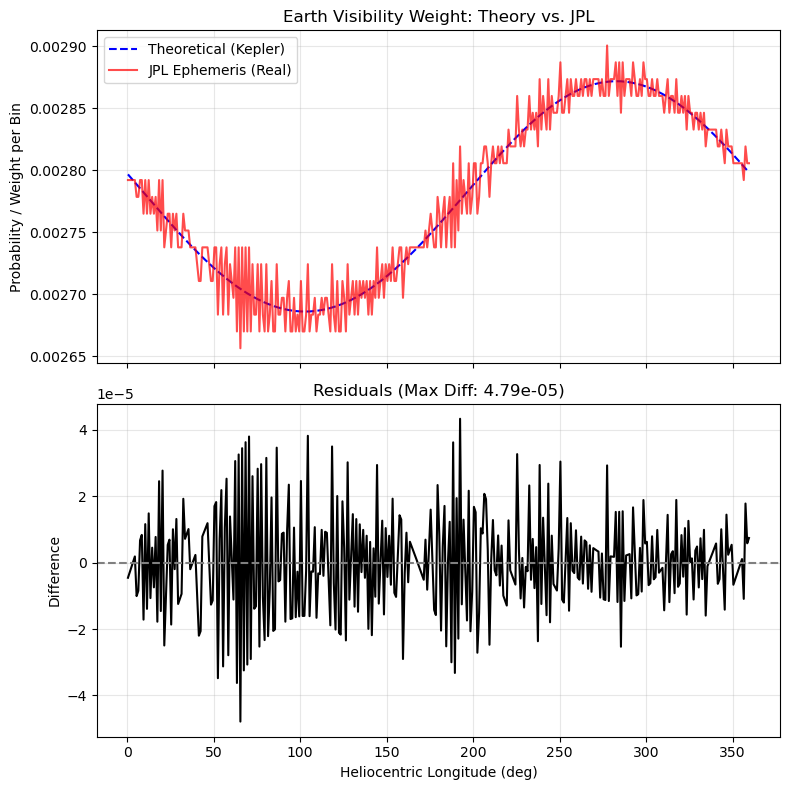

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# ============================
# 1. Set parameters (Original code parameters)
# ============================
ECCENTRICITY_EARTH = 0.0167
PERIHELION_LON_EARTH = 102.92

# ============================
# 2. Define theoretical formula function (Old Way)
# ============================
def get_theoretical_pdf(bins):
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    # Simulate original logic
    anomaly_rad = np.radians(bin_centers - PERIHELION_LON_EARTH)
    angular_velocity = (1 + ECCENTRICITY_EARTH * np.cos(anomaly_rad))**2
    weights = 1.0 / angular_velocity
    # Normalize to probability density (PDF)
    return bin_centers, weights / np.sum(weights)

# ============================
# 3. Define JPL data function (New Way)
# ============================
def get_jpl_pdf(file_path, bins):
    # Read data
    df = pd.read_parquet(file_path)
    lon = df['399_lon'].values
    # Ensure 0-360 range
    lon = (lon + 360) % 360
    
    # Use the same bins for histogram statistics
    hist, _ = np.histogram(lon, bins=bins, density=True)
    
    # Note: histogram density=True means integral area is 1
    # We need to convert to "relative weight sum per bin = 1" for direct comparison with theoretical formula values
    # i.e., hist * bin_width
    bin_width = bins[1] - bins[0]
    weights = hist * bin_width
    
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    return bin_centers, weights

# ============================
# 4. Execute comparison
# ============================
# Assume file path is here
file_path = '../../data/ready/781_planets_dwarfs_asteroids_lonlat.parquet'
# If file is missing, modify path or manually specify dummy data for testing

try:
    # 1. Create detailed Grid (e.g., 1 point per degree, 360 points total)
    test_bins = np.linspace(0, 360, 361) 
    
    # 2. Calculate two sets of weights
    centers, w_theory = get_theoretical_pdf(test_bins)
    centers, w_jpl = get_jpl_pdf(file_path, test_bins)
    
    # 3. Calculate differences
    diff = w_jpl - w_theory
    rel_diff_percent = (diff / w_theory) * 100
    
    max_diff = np.max(np.abs(diff))
    max_rel_diff = np.max(np.abs(rel_diff_percent))
    mse = np.sqrt(np.mean(diff**2))

    print(f"--- Difference Analysis Report ---")
    print(f"Max Absolute Error (Weight): {max_diff:.6f}")
    print(f"Max Relative Error (%):      {max_rel_diff:.4f}%")
    print(f"Root Mean Square Error (RMSE):     {mse:.6f}")
    print(f"--------------------")
    
    if max_rel_diff < 1.0:
        print("Conclusion: Difference is minimal (<1%), original formula is very accurate.")
    else:
        print("Conclusion: Difference is significant, replacement recommended.")

    # ============================
    # 5. Plotting verification
    # ============================
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
    
    # Top: Distribution comparison
    ax1.plot(centers, w_theory, 'b--', label='Theoretical (Kepler)', lw=1.5)
    ax1.plot(centers, w_jpl, 'r-', label='JPL Ephemeris (Real)', alpha=0.7, lw=1.5)
    ax1.set_ylabel('Probability / Weight per Bin')
    ax1.set_title('Earth Visibility Weight: Theory vs. JPL')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Bottom: Residuals (JPL - Theory)
    ax2.plot(centers, diff, 'k-', label='Difference (JPL - Theory)')
    ax2.axhline(0, color='gray', ls='--')
    ax2.set_ylabel('Difference')
    ax2.set_xlabel('Heliocentric Longitude (deg)')
    ax2.set_title(f'Residuals (Max Diff: {max_diff:.2e})')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Failed to run comparison, please check file path: {e}")